In [29]:
# 02_sql_analysis.ipynb

# 1. Import Libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load Cleaned Data
df = pd.read_csv("../data/cleaned_transactions.csv")
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1,0


In [4]:
# 3. Create In-Memory SQLite DB
conn = sqlite3.connect(":memory:")
df.to_sql("transactions", conn, index=False, if_exists="replace")


6362620

In [13]:
# Total Fraud vs Non-Fraud Counts
query = """
    SELECT isFraud, COUNT(*) AS count
    FROM transactions
    GROUP BY isFraud
"""
pd.read_sql_query(query, conn)


,isFraud,count
0,0,6354407
1,1,8213


In [14]:
# 5. Fraud trend over days
query = """
SELECT step / 24 AS day,
       SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) AS fraud_count,
       COUNT(*) AS total_txns,
       ROUND(100.0 * SUM(CASE WHEN isFraud = 1 THEN 1 ELSE 0 END) / COUNT(*), 2) AS fraud_rate_pct
FROM transactions
GROUP BY day
ORDER BY day
"""
fraud_trend = pd.read_sql_query(query, conn)
fraud_trend.head()


,day,fraud_count,total_txns,fraud_rate_pct
0,0,265,571039,0.05
1,1,305,452761,0.07
2,2,306,6749,4.53
3,3,272,21904,1.24
4,4,244,12995,1.88


/Users/mahalakshmirajabattula/Library/Mobile Documents/com~apple~CloudDocs/transaction_forensic_project/venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


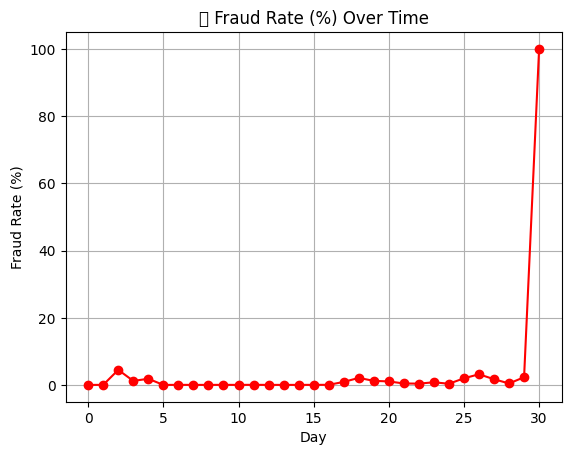

In [ ]:
# 6. Plot fraud rate over days
plt.plot(fraud_trend["day"], fraud_trend["fraud_rate_pct"], marker="o", color="red")
plt.title("Fraud Rate (%) Over Time")
plt.xlabel("Day")
plt.ylabel("Fraud Rate (%)")
plt.grid(True)
plt.show()


In [18]:
# 7. Top 10 suspicious recipients by fraud count
query = """
SELECT nameDest, COUNT(*) AS fraud_count, SUM(amount) AS total_fraud_amount
FROM transactions
WHERE isFraud = 1
GROUP BY nameDest
ORDER BY fraud_count DESC
LIMIT 10
"""
pd.read_sql_query(query, conn)


,nameDest,fraud_count,total_fraud_amount
0,C967226405,2,1416085.46
1,C964377943,2,6014862.39
2,C935310781,2,544064.51
3,C904300960,2,1427683.17
4,C803116137,2,1744765.69
5,C686334805,2,629142.78
6,C668046170,2,10160088.68
7,C650699445,2,408028.65
8,C644163395,2,1196176.06
9,C643624257,2,3071716.97


In [19]:
# 8. Highest value fraud cases
query = """
SELECT nameOrig, nameDest, amount, step
FROM transactions
WHERE isFraud = 1
ORDER BY amount DESC
LIMIT 10
"""
pd.read_sql_query(query, conn)


,nameOrig,nameDest,amount,step
0,C7162498,C945327594,10000000.0,4
1,C351297720,C766681183,10000000.0,4
2,C416779475,C380259496,10000000.0,19
3,C2050703310,C1622860679,10000000.0,19
4,C1439740840,C875288652,10000000.0,33
5,C29118015,C1379703840,10000000.0,33
6,C53057884,C588547519,10000000.0,72
7,C1438388258,C1089455271,10000000.0,72
8,C1237313447,C1468356154,10000000.0,82
9,C1079335762,C615227407,10000000.0,82


In [25]:
# 9. Fraud where entire balance was drained
query = """
SELECT nameOrig, oldbalanceOrg, newbalanceOrig, amount
FROM transactions
WHERE isFraud = 1
  AND newbalanceOrig = 0
  AND oldbalanceOrg = amount
"""
pd.read_sql_query(query, conn)


,nameOrig,oldbalanceOrg,newbalanceOrig,amount
0,C1305486145,181.00,0.0,181.00
1,C840083671,181.00,0.0,181.00
2,C1420196421,2806.00,0.0,2806.00
3,C2101527076,2806.00,0.0,2806.00
4,C137533655,20128.00,0.0,20128.00
...,...,...,...,...
8019,C786484425,339682.13,0.0,339682.13
8020,C1529008245,6311409.28,0.0,6311409.28
8021,C1162922333,6311409.28,0.0,6311409.28
8022,C1685995037,850002.52,0.0,850002.52


In [21]:
df.columns.tolist()


['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'hour',
 'day']

In [22]:
pd.read_sql_query("PRAGMA table_info(transactions);", conn)


,cid,name,type,notnull,dflt_value,pk
0,0,step,INTEGER,0,None,0
1,1,type,TEXT,0,None,0
2,2,amount,REAL,0,None,0
3,3,nameOrig,TEXT,0,None,0
4,4,oldbalanceOrg,REAL,0,None,0
5,5,newbalanceOrig,REAL,0,None,0
6,6,nameDest,TEXT,0,None,0
7,7,oldbalanceDest,REAL,0,None,0
8,8,newbalanceDest,REAL,0,None,0
9,9,isFraud,INTEGER,0,None,0


In [26]:
# 10. Circular transaction detection (simplified 2-hop loop)
query = """
SELECT 
    t1.nameOrig AS sender1,
    t1.nameDest AS receiver1,
    t2.nameOrig AS sender2,
    t2.nameDest AS receiver2,
    t1.amount
FROM transactions t1
JOIN transactions t2
  ON t1.nameDest = t2.nameOrig
WHERE t1.nameOrig = t2.nameDest
  AND t1.nameOrig != t1.nameDest
  AND t1.isFraud = 1
  AND t2.isFraud = 1
LIMIT 20
"""
pd.read_sql_query(query, conn)


,sender1,receiver1,sender2,receiver2,amount


In [27]:
# Total amount lost to fraud
missing_millions = df[df['isFraud'] == 1]['amount'].sum()
print(f"💸 Total Money Lost to Fraud: ₹{missing_millions:,.0f}")

💸 Total Money Lost to Fraud: ₹12,056,415,428
